Sabari Kumar, CSU Chemistry Theory Summer School 2023

This jupyter notebook provides a quick hands on introduction to building SVM and Decision Tree models with scikit learn.

In [1]:
import pandas as pd

import sklearn


import rdkit
from rdkit import Chem
from rdkit import RDLogger    
RDLogger.DisableLog('rdApp.*')

import numpy as np
import datamol as dm

from tqdm import tqdm

random_state = 42

#### TABLE OF CONTENTS
* [Cleaning the Data](#cd)
* [SVM Classifer](#svm)
* [Decision Tree Regressor](#dtr)

#### Cleaning the Data <a name="cd"></a>

In [2]:
db = pd.read_csv('curated-solubility-dataset.csv')
aqsol = db[['ID', 'Name', 'SMILES', 'Solubility']].copy()
aqsol

,ID,Name,SMILES,Solubility
0,A-3,"N,N,N-trimethyloctadecan-1-aminium bromide",[Br-].CCCCCCCCCCCCCCCCCC[N+](C)(C)C,-3.616127
1,A-4,Benzo[cd]indol-2(1H)-one,O=C1Nc2cccc3cccc1c23,-3.254767
2,A-5,4-chlorobenzaldehyde,Clc1ccc(C=O)cc1,-2.177078
3,A-8,"zinc bis[2-hydroxy-3,5-bis(1-phenylethyl)benzo...",[Zn++].CC(c1ccccc1)c2cc(C(C)c3ccccc3)c(O)c(c2)...,-3.924409
4,A-9,4-({4-[bis(oxiran-2-ylmethyl)amino]phenyl}meth...,C1OC1CN(CC2CO2)c3ccc(Cc4ccc(cc4)N(CC5CO5)CC6CO...,-4.662065
...,...,...,...,...
9977,I-84,tetracaine,C(c1ccc(cc1)NCCCC)(=O)OCCN(C)C,-3.010000
9978,I-85,tetracycline,OC1=C(C(C2=C(O)[C@@](C(C(C(N)=O)=C(O)[C@H]3N(C...,-2.930000
9979,I-86,thymol,c1(cc(ccc1C(C)C)C)O,-2.190000
9980,I-93,verapamil,COc1ccc(CCN(C)CCCC(C#N)(C(C)C)c2ccc(OC)c(OC)c2...,-3.980000


The aqsol dataset is a curated dataset of aqueous solubility measurements for various compounds. We'll reformat it for use with our ML methods

aqsol ref:
 - Sorkun, Murat Cihan, Abhishek Khetan, and Süleyman Er. "AqSolDB, a curated reference set of aqueous solubility and 2D descriptors for a diverse set of compounds." Scientific data 6.1 (2019): 143.

 ---
 
 First, let's add a column of rdkit mol objects and cannonicalize SMILES strings for completeness

In [3]:
aqsol['SMILES'] = aqsol['SMILES'].map(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x)))
aqsol['mol'] = aqsol['SMILES'].map(lambda x: Chem.MolFromSmiles(x))
aqsol.head()

,ID,Name,SMILES,Solubility,mol
0,A-3,"N,N,N-trimethyloctadecan-1-aminium bromide",CCCCCCCCCCCCCCCCCC[N+](C)(C)C.[Br-],-3.616127,<rdkit.Chem.rdchem.Mol object at 0x14e054bcdba0>
1,A-4,Benzo[cd]indol-2(1H)-one,O=C1Nc2cccc3cccc1c23,-3.254767,<rdkit.Chem.rdchem.Mol object at 0x14e054ababa0>
2,A-5,4-chlorobenzaldehyde,O=Cc1ccc(Cl)cc1,-2.177078,<rdkit.Chem.rdchem.Mol object at 0x14e054abab30>
3,A-8,"zinc bis[2-hydroxy-3,5-bis(1-phenylethyl)benzo...",CC(c1ccccc1)c1cc(C(=O)[O-])c(O)c(C(C)c2ccccc2)...,-3.924409,<rdkit.Chem.rdchem.Mol object at 0x14e054abac10>
4,A-9,4-({4-[bis(oxiran-2-ylmethyl)amino]phenyl}meth...,c1cc(N(CC2CO2)CC2CO2)ccc1Cc1ccc(N(CC2CO2)CC2CO...,-4.662065,<rdkit.Chem.rdchem.Mol object at 0x14e054abac80>


Let's calculate some basic descriptors for each row. We'll use datamol, a convenient wrapper for rdkit. Datamol has many other functions, and offers a more user-friendly interface than rdkit's somewhat scattered functions.

In [11]:
desc_0d_df = dm.descriptors.batch_compute_many_descriptors(aqsol['mol'], n_jobs = 8, batch_size = 'auto')
aqsol_0d = pd.merge(aqsol, desc_0d_df, right_index=True, left_index=True)

[23:03:27] WARNING: not removing hydrogen atom without neighbors
[23:03:27] WARNING: not removing hydrogen atom without neighbors
[23:03:27] WARNING: not removing hydrogen atom without neighbors
[23:03:27] WARNING: not removing hydrogen atom without neighbors
[23:03:27] WARNING: not removing hydrogen atom without neighbors
[23:03:27] WARNING: not removing hydrogen atom without neighbors
[23:03:27] WARNING: not removing hydrogen atom without neighbors
[23:03:27] WARNING: not removing hydrogen atom without neighbors
[23:03:27] WARNING: not removing hydrogen atom without neighbors
[23:03:27] WARNING: not removing hydrogen atom without neighbors
[23:03:27] WARNING: not removing hydrogen atom without neighbors
[23:03:27] WARNING: not removing hydrogen atom without neighbors
[23:03:27] WARNING: not removing hydrogen atom without neighbors
[23:03:27] WARNING: not removing hydrogen atom without neighbors
[23:03:27] WARNING: not removing hydrogen atom without neighbors
[23:03:27] WARNING: not r

In [12]:
aqsol_0d.head()

,ID,Name,SMILES,Solubility,mol,mw,fsp3,n_lipinski_hba,n_lipinski_hbd,n_rings,...,sas,n_aliphatic_carbocycles,n_aliphatic_heterocyles,n_aliphatic_rings,n_aromatic_carbocycles,n_aromatic_heterocyles,n_aromatic_rings,n_saturated_carbocycles,n_saturated_heterocyles,n_saturated_rings
0,A-3,"N,N,N-trimethyloctadecan-1-aminium bromide",CCCCCCCCCCCCCCCCCC[N+](C)(C)C.[Br-],-3.616127,<rdkit.Chem.rdchem.Mol object at 0x14e054bcdba0>,391.281363,1.000000,1,0,0,...,2.039968,0,0,0,0,0,0,0,0,0
1,A-4,Benzo[cd]indol-2(1H)-one,O=C1Nc2cccc3cccc1c23,-3.254767,<rdkit.Chem.rdchem.Mol object at 0x14e054ababa0>,169.052764,0.000000,2,1,3,...,1.994874,0,1,1,2,0,2,0,0,0
2,A-5,4-chlorobenzaldehyde,O=Cc1ccc(Cl)cc1,-2.177078,<rdkit.Chem.rdchem.Mol object at 0x14e054abab30>,140.002892,0.000000,1,0,1,...,1.561055,0,0,0,1,0,1,0,0,0
3,A-8,"zinc bis[2-hydroxy-3,5-bis(1-phenylethyl)benzo...",CC(c1ccccc1)c1cc(C(=O)[O-])c(O)c(C(C)c2ccccc2)...,-3.924409,<rdkit.Chem.rdchem.Mol object at 0x14e054abac10>,754.227281,0.173913,6,2,6,...,4.209538,0,0,0,6,0,6,0,0,0
4,A-9,4-({4-[bis(oxiran-2-ylmethyl)amino]phenyl}meth...,c1cc(N(CC2CO2)CC2CO2)ccc1Cc1ccc(N(CC2CO2)CC2CO...,-4.662065,<rdkit.Chem.rdchem.Mol object at 0x14e054abac80>,422.220557,0.520000,6,0,6,...,3.753237,0,4,4,2,0,2,0,4,4


<Axes: >

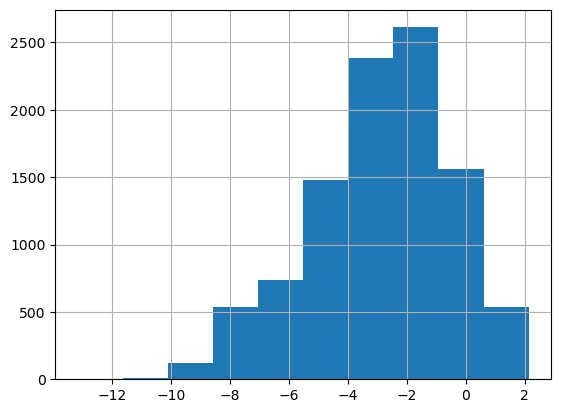

In [13]:
aqsol['Solubility'].hist()

#### Support Vector Machines Classifier <a name="svm"></a>

Now, lets get into the SVM stuff. First, we'll classify the compounds using an arbitrary solubility cutoff of -3. 

In [14]:
aqsol_0d['sol_class'] = aqsol_0d['Solubility'].map(lambda x : -1 if x<-3 else 1)
aqsol_0d.head()

,ID,Name,SMILES,Solubility,mol,mw,fsp3,n_lipinski_hba,n_lipinski_hbd,n_rings,...,n_aliphatic_carbocycles,n_aliphatic_heterocyles,n_aliphatic_rings,n_aromatic_carbocycles,n_aromatic_heterocyles,n_aromatic_rings,n_saturated_carbocycles,n_saturated_heterocyles,n_saturated_rings,sol_class
0,A-3,"N,N,N-trimethyloctadecan-1-aminium bromide",CCCCCCCCCCCCCCCCCC[N+](C)(C)C.[Br-],-3.616127,<rdkit.Chem.rdchem.Mol object at 0x14e054bcdba0>,391.281363,1.000000,1,0,0,...,0,0,0,0,0,0,0,0,0,-1
1,A-4,Benzo[cd]indol-2(1H)-one,O=C1Nc2cccc3cccc1c23,-3.254767,<rdkit.Chem.rdchem.Mol object at 0x14e054ababa0>,169.052764,0.000000,2,1,3,...,0,1,1,2,0,2,0,0,0,-1
2,A-5,4-chlorobenzaldehyde,O=Cc1ccc(Cl)cc1,-2.177078,<rdkit.Chem.rdchem.Mol object at 0x14e054abab30>,140.002892,0.000000,1,0,1,...,0,0,0,1,0,1,0,0,0,1
3,A-8,"zinc bis[2-hydroxy-3,5-bis(1-phenylethyl)benzo...",CC(c1ccccc1)c1cc(C(=O)[O-])c(O)c(C(C)c2ccccc2)...,-3.924409,<rdkit.Chem.rdchem.Mol object at 0x14e054abac10>,754.227281,0.173913,6,2,6,...,0,0,0,6,0,6,0,0,0,-1
4,A-9,4-({4-[bis(oxiran-2-ylmethyl)amino]phenyl}meth...,c1cc(N(CC2CO2)CC2CO2)ccc1Cc1ccc(N(CC2CO2)CC2CO...,-4.662065,<rdkit.Chem.rdchem.Mol object at 0x14e054abac80>,422.220557,0.520000,6,0,6,...,0,4,4,2,0,2,0,4,4,-1


In [15]:
print(len(aqsol_0d[aqsol_0d['sol_class']==1]))

5687


In [16]:
Y = aqsol_0d['sol_class']
aqsol_0d = aqsol_0d.drop(['ID', 'Name', 'SMILES', 'Solubility', 'mol', 'sol_class'], axis = 1)
aqsol_0d.head()

,mw,fsp3,n_lipinski_hba,n_lipinski_hbd,n_rings,n_hetero_atoms,n_heavy_atoms,n_rotatable_bonds,n_radical_electrons,tpsa,...,sas,n_aliphatic_carbocycles,n_aliphatic_heterocyles,n_aliphatic_rings,n_aromatic_carbocycles,n_aromatic_heterocyles,n_aromatic_rings,n_saturated_carbocycles,n_saturated_heterocyles,n_saturated_rings
0,391.281363,1.000000,1,0,0,2,23,17,0,0.00,...,2.039968,0,0,0,0,0,0,0,0,0
1,169.052764,0.000000,2,1,3,2,13,0,0,29.10,...,1.994874,0,1,1,2,0,2,0,0,0
2,140.002892,0.000000,1,0,1,2,9,1,0,17.07,...,1.561055,0,0,0,1,0,1,0,0,0
3,754.227281,0.173913,6,2,6,7,53,10,0,120.72,...,4.209538,0,0,0,6,0,6,0,0,0
4,422.220557,0.520000,6,0,6,6,31,12,0,56.60,...,3.753237,0,4,4,2,0,2,0,4,4


In [17]:
from sklearn import model_selection
x_train, x_test, y_train, y_test = model_selection.train_test_split(aqsol_0d, Y, train_size=0.9, random_state = random_state)

In [18]:
x_train

,mw,fsp3,n_lipinski_hba,n_lipinski_hbd,n_rings,n_hetero_atoms,n_heavy_atoms,n_rotatable_bonds,n_radical_electrons,tpsa,...,sas,n_aliphatic_carbocycles,n_aliphatic_heterocyles,n_aliphatic_rings,n_aromatic_carbocycles,n_aromatic_heterocyles,n_aromatic_rings,n_saturated_carbocycles,n_saturated_heterocyles,n_saturated_rings
7238,151.063329,0.125000,3,2,1,3,11,2,0,52.32,...,1.462462,0,0,0,1,0,1,0,0,0
2127,72.057515,0.750000,1,0,0,1,5,2,0,17.07,...,2.734983,0,0,0,0,0,0,0,0,0
6129,221.041526,0.875000,2,2,0,3,11,5,0,43.09,...,3.197251,0,0,0,0,0,0,0,0,0
8201,305.917276,0.000000,1,0,2,5,17,2,0,9.23,...,1.826144,0,0,0,2,0,2,0,0,0
960,246.009104,0.666667,0,0,0,9,15,3,0,0.00,...,3.025687,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,230.151809,0.833333,4,2,0,4,16,7,0,74.60,...,2.653215,0,0,0,0,0,0,0,0,0
5191,256.125201,0.100000,0,0,4,0,20,1,0,0.00,...,1.826188,0,0,0,4,0,4,0,0,0
5390,292.025084,0.000000,6,2,2,7,20,3,0,92.47,...,1.716195,0,0,0,2,0,2,0,0,0
860,149.990419,0.333333,0,0,0,6,9,0,0,0.00,...,3.372386,0,0,0,0,0,0,0,0,0


In [19]:
# modified from https://www.pycodemates.com/2022/10/svm-kernels-polynomial-kernel.html

class SVM:
    def __init__(self, C = 1.0, kernel = None, gamma = None, deg = None):
        self.C = C # Error term for "fuzziness"
        self.w = 0
        self.b = 0
        self.gamma = gamma
        self.deg = deg        

    # Hinge loss takes care of "fuzziness"
    def hingeloss(self, w, b, x, y):
        # Regularizer term
        reg = 0.5 * (w * w)

        for i in range(x.shape[0]):
            # Optimization term
            opt_term = y[i] * ((np.dot(w, x[i])) + b)

            # calculating loss
            loss = reg + self.C * max(0, 1-opt_term)
        return loss[0][0]

    
    def transform_poly(self, X, Y=None):
        X['x1^2'] = X['x1'] ** self.deg
        X['x2^2'] = X['x2'] ** self.deg
        # Finding the product of X1 and X2
        X['x1 * x2'] = X['x1'] * X['x2']
        # Converting dataset to numpy array
        X = X.to_numpy()
        if Y.size != 0:
            Y = Y.to_numpy()
            return X, Y
        else:
            return X
        
        

    def fit(self, X, Y, batch_size=100, learning_rate=0.001, epochs=1000):
        # The number of features in X
        number_of_features = X.shape[1]

        # The number of Samples in X
        number_of_samples = X.shape[0]

        c = self.C

        # Creating ids from 0 to number_of_samples - 1
        ids = np.arange(number_of_samples)

        # Shuffling the samples randomly
        np.random.shuffle(ids)

        # creating an array of zeros
        w = np.zeros((1, number_of_features))
        b = 0
        losses = []

        # Gradient Descent logic
        for i in range(epochs):
            # Calculating the Hinge Loss
            l = self.hingeloss(w, b, X, Y)

            # Appending all losses 
            losses.append(l)
            
            # Starting from 0 to the number of samples with batch_size as interval
            for batch_initial in range(0, number_of_samples, batch_size):
                gradw = 0
                gradb = 0

                for j in range(batch_initial, batch_initial+ batch_size):
                    if j < number_of_samples:
                        x = ids[j]
                        ti = Y[x] * (np.dot(w, X[x].T) + b)

                        if ti > 1:
                            gradw += 0
                            gradb += 0
                        else:
                            # Calculating the gradients

                            #w.r.t w 
                            gradw += c * Y[x] * X[x]
                            # w.r.t b
                            gradb += c * Y[x]

                # Updating weights and bias
                w = w - learning_rate * w + learning_rate * gradw
                b = b + learning_rate * gradb
        
        self.w = w
        self.b = b

        return self.w, self.b, losses

    def predict(self, X):
        
        prediction = np.dot(X, self.w[0]) + self.b # w.x + b
        return np.sign(prediction)
    

Now, lets use scikit learn to build an SVM model:

In [20]:
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [21]:
c0_svm = svm.SVC(random_state=42)
c0_svm.fit(x_train, y_train)

SVC(random_state=42)

In [22]:
y_train_pred = c0_svm.predict(x_train)
y_test_pred = c0_svm.predict(x_test)

In [23]:
len(y_train)

8983

In [24]:
print(f'Model training set accuracy: {len([x for ind, x in enumerate(y_train_pred) if x == list(y_train)[ind]])/len(y_train)}')
print(f'Model test set accuracy: {len([x for ind, x in enumerate(y_test_pred) if x == list(y_test)[ind]])/len(y_test)}')

Model training set accuracy: 0.7892686185016141
Model test set accuracy: 0.8048048048048048


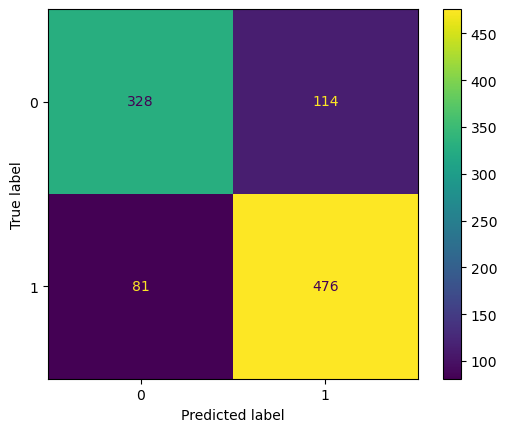

In [25]:
cm = confusion_matrix(y_test, y_test_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()

Lets see if we can make the model accuracy better!

In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [27]:
pipe = make_pipeline(StandardScaler(), svm.SVC(random_state=random_state))
pipe.fit(x_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(random_state=42))])

In [28]:
pipe_train_pred = pipe.predict(x_train)
pipe_test_pred = pipe.predict(x_test)

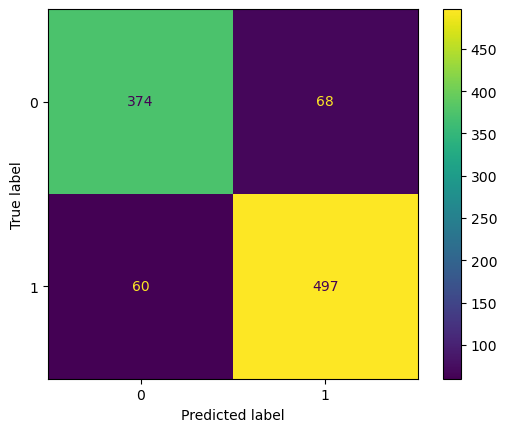

In [29]:
cm = confusion_matrix(y_test, pipe_test_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()

In [30]:
print(f'Model training set accuracy: {len([x for ind, x in enumerate(pipe_train_pred) if x == list(y_train)[ind]])/len(y_train)}')
print(f'Model test set accuracy: {len([x for ind, x in enumerate(pipe_test_pred) if x == list(y_test)[ind]])/len(y_test)}')

Model training set accuracy: 0.8726483357452967
Model test set accuracy: 0.8718718718718719


In [31]:
pipe.score(x_test, y_test)

0.8718718718718719

Lets do a quick permutation feature importance test to see which features are most important. This feature importance is the decrease in the model accuracy when a single feature value is randomly shuffled - this breaks the relationship between the feature and the data label. 

Before we do this, though, we need to do a cross validation on the training data to assess if the model is overfit. Importantly, features that are low importance for a bad model could be very important for a good model. In the wise words of Brunton and Kutz, "if you don't cross validate, you is dumb".    
  
ref:  
S. L. Brunton and J. N. Kutz, Data-driven science and engineering: Machine learning, dynamical systems, and control,
Cambridge Univ. Press (2019).)

In [32]:
from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance

In [33]:
scores = cross_val_score(pipe, x_train, y_train, cv=5)

In [34]:
print(f'Scaled SVM with an rbf kernel yields a model with accuracy {scores.mean():.3f} and std dev. {scores.std():.3f}')

Scaled SVM with an rbf kernel yields a model with accuracy 0.856 and std dev. 0.007


In [35]:
r = permutation_importance(pipe, x_test, y_test, n_repeats = 30, random_state = random_state)

In [36]:
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(x_test.columns[i], '\t', f'{r.importances_mean[i]:.3f}', '\t', f'{r.importances_std[i]:.3f}')

clogp 	 0.267 	 0.014
mw 	 0.040 	 0.006
n_heavy_atoms 	 0.023 	 0.006
n_lipinski_hba 	 0.019 	 0.004
n_lipinski_hbd 	 0.016 	 0.004
qed 	 0.014 	 0.004
sas 	 0.013 	 0.005
n_hetero_atoms 	 0.012 	 0.003
tpsa 	 0.011 	 0.003
n_aliphatic_heterocyles 	 0.008 	 0.003
n_aliphatic_carbocycles 	 0.007 	 0.003
n_rotatable_bonds 	 0.006 	 0.003
n_radical_electrons 	 0.005 	 0.001
n_aromatic_heterocyles 	 0.005 	 0.002


#### Decision Tree Classifier <a name="dtr"></a>

Lets see how a decision tree regressor performs. Decision trees are notorious for overfitting data when the number of features is high; we'll add a PCA step to the pipeline prior to the regressor model to reduce the feature space dimensionality. Notice that we've omitted the standard scaler in the pipeline - the decision tree is much less sensitive to this.

In [106]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.decomposition import PCA

pipe = make_pipeline(PCA(n_components = 14), DecisionTreeClassifier(random_state=random_state))
pipe.fit(x_train, y_train)
tree = DecisionTreeClassifier(random_state = random_state)
tree.fit(x_train, y_train)


DecisionTreeClassifier(random_state=42)

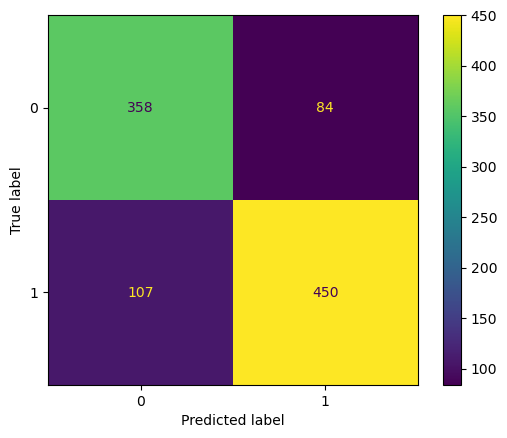

In [103]:
pipe_train_pred = pipe.predict(x_train)
pipe_test_pred = pipe.predict(x_test)

cm = confusion_matrix(y_test, pipe_test_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()

In [104]:
pipe.score(x_test, y_test)

0.8088088088088088

[Text(0.32589621836232635, 0.9772727272727273, 'x[1] <= -18.572\ngini = 0.49\nsamples = 8983\nvalue = [3853, 5130]'),
 Text(0.0927276030221584, 0.9318181818181818, 'x[0] <= -94.357\ngini = 0.348\nsamples = 2797\nvalue = [2169, 628]'),
 Text(0.030563021458025093, 0.8863636363636364, 'x[7] <= -0.353\ngini = 0.5\nsamples = 507\nvalue = [251, 256]'),
 Text(0.014567994186810013, 0.8409090909090909, 'x[4] <= -0.011\ngini = 0.324\nsamples = 231\nvalue = [184, 47]'),
 Text(0.008964919499575391, 0.7954545454545454, 'x[11] <= -0.14\ngini = 0.484\nsamples = 61\nvalue = [36, 25]'),
 Text(0.004482459749787696, 0.75, 'x[2] <= 0.891\ngini = 0.291\nsamples = 34\nvalue = [28, 6]'),
 Text(0.002241229874893848, 0.7045454545454546, 'x[2] <= 0.449\ngini = 0.494\nsamples = 9\nvalue = [5, 4]'),
 Text(0.001120614937446924, 0.6590909090909091, 'gini = 0.0\nsamples = 5\nvalue = [5, 0]'),
 Text(0.003361844812340772, 0.6590909090909091, 'gini = 0.0\nsamples = 4\nvalue = [0, 4]'),
 Text(0.006723689624681544, 0.704

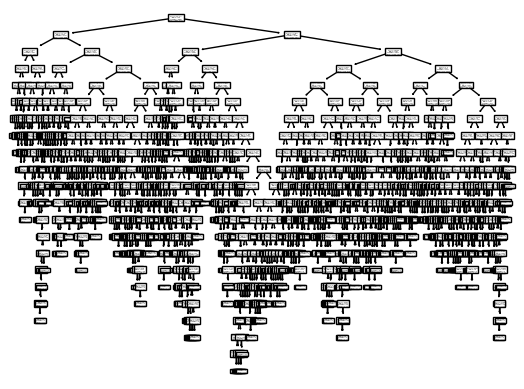

In [105]:
tree.plot_tree(pipe[1])

In [107]:
import graphviz
tree_data = tree.export_graphviz(pipe[1], out_file = None,
                                filled = True, rounded = True,
                                special_characters = True)

ModuleNotFoundError: No module named 'graphviz'

In [ ]:
graph = graphviz.Source(tree_data)
graph

Decision tree methods are notorious for creating very complex trees that do not generalize data well - ie., overfitting. Note the number of nodes that have single samples.  
This can be abated by limitting the max depth of the tree or setting the number of minimum samples at each node.  
  
  
Other problem with decision trees center around instability and local optimality. Oftentimes, slight variations in the data (ie., as you would see with cross validation) result in completely different decision tree structure - instability. The problem of local optimality is more subtle, and arrises from the practical methods used to implement decision tree algorithms. Since the time complexity of learning an optimal decision tree has been proven to be NP-complete, most decision tree implementations make use of heuruistics such as the greedy algorithm. As a reminder, NP complete problems have solutions that can be **verified** quickly; however, there is no known way to **find** a solution quickly. Greedy algorithms make a locally optimal choice at each step, resulting in an **approximation** of a globally optimal solution.   
Both these problems can be mitigated by using an ensemble of trees - this is the approach taken by random forest and gradient boosting tree methods. 

In [47]:
from sklearn.ensemble import RandomForestClassifier

pipe = make_pipeline(PCA(n_components = 14), RandomForestClassifier(max_depth = 5, random_state=random_state))
pipe.fit(x_train, y_train)

Pipeline(steps=[('pca', PCA(n_components=14)),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=5, random_state=42))])

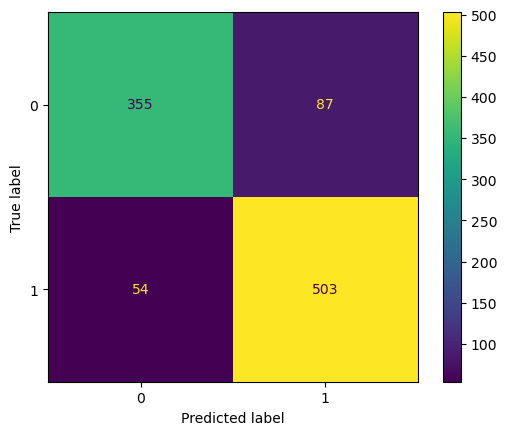

In [48]:
pipe_train_pred = pipe.predict(x_train)
pipe_test_pred = pipe.predict(x_test)

cm = confusion_matrix(y_test, pipe_test_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()

In [49]:
pipe.score(x_test, y_test)

0.8588588588588588

In [53]:
!conda install -c conda-forge py-xgboost
from xgboost import XGBClassifier

In [54]:
bst = XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic')
bst.fit(x_train, y_train)

bst_train_pred = bst.predict(x_train)
bst_test_pred = bst.predict(x_test)

cm = confusion_matrix(y_test, bst_test_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()

ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1], got [-1  1]

In [110]:
y_train_zeros = [x if x==1 else 0 for x in y_train]
set(y_train_zeros)

[0, 1]


In [56]:
y_test_zeros = [x if x==1 else 0 for x in y_test]
set(y_test_zeros)

{0, 1}

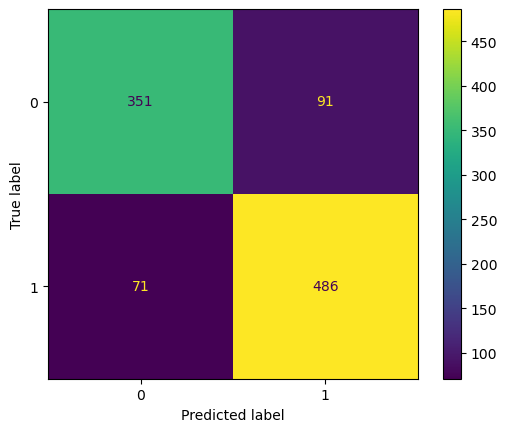

In [111]:
bst.fit(x_train, y_train_zeros)

bst_train_pred = bst.predict(x_train)
bst_test_pred = bst.predict(x_test)

cm = confusion_matrix(y_test_zeros, bst_test_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()

In [58]:
bst.score(x_test, y_test_zeros)

0.8378378378378378

Let's do a quick SHAP analysis of this data

In [97]:
import shap
import xgboost

rfc = RandomForestClassifier(max_depth = 5, random_state=random_state).fit(x_train, y_train)
explainer = shap.Explainer(rfc)
shap_values = explainer(x_train)

In [60]:
np.__version__

'1.23.5'

In [70]:
x_train_red = x_train[['mw', 'n_heavy_atoms', 'n_lipinski_hba', 'n_radical_electrons', 'sas', 'tpsa']]

In [82]:
x_train_red = x_train_red.astype({'mw':'float', 'n_heavy_atoms':'int', 'n_lipinski_hba': 'int', 'n_radical_electrons': 'int', 'sas': 'float', 'tpsa': 'float'})

In [90]:
rfc = RandomForestClassifier(max_depth = 5, random_state=random_state).fit(x_train_red, y_train)
explainer = shap.TreeExplainer(rfc)
shap_values = explainer(x_train_red)

In [93]:
shap.plots.beeswarm(shap_values)
#shap.plots.waterfall(shap_values[0])

ValueError: The beeswarm plot does not support plotting explanations with instances that have more than one dimension!

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


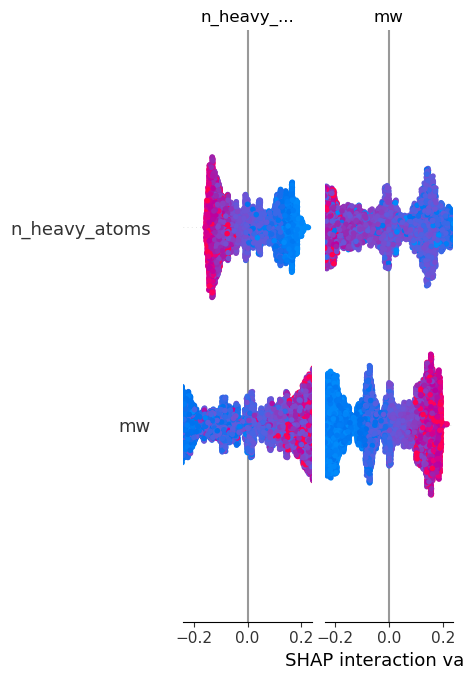

In [91]:
shap.summary_plot(shap_values, feature_names=x_train_red.columns, plot_type = 'bar')

 99%|===================| 32327/32561 [01:12<00:00]        No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


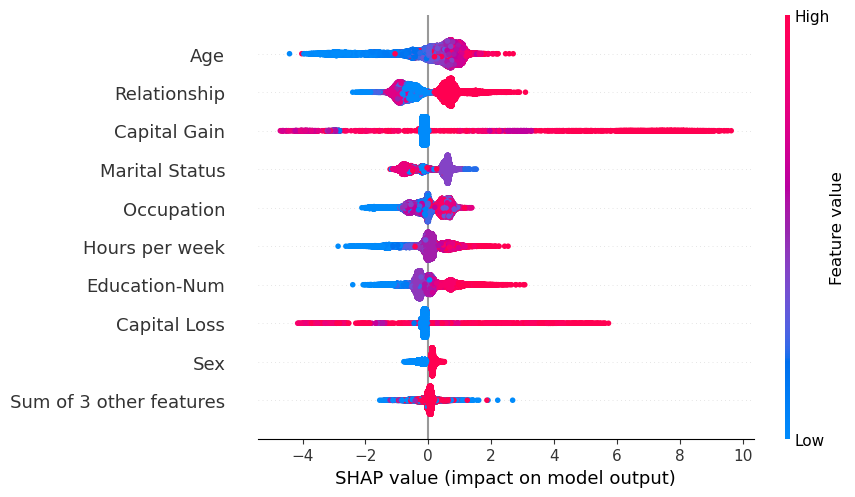

In [99]:
X,y = shap.datasets.adult()
model = xgboost.XGBClassifier().fit(X, y)
explainer = shap.Explainer(model, X)
shap_values = explainer(X)
shap.plots.beeswarm(shap_values)


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


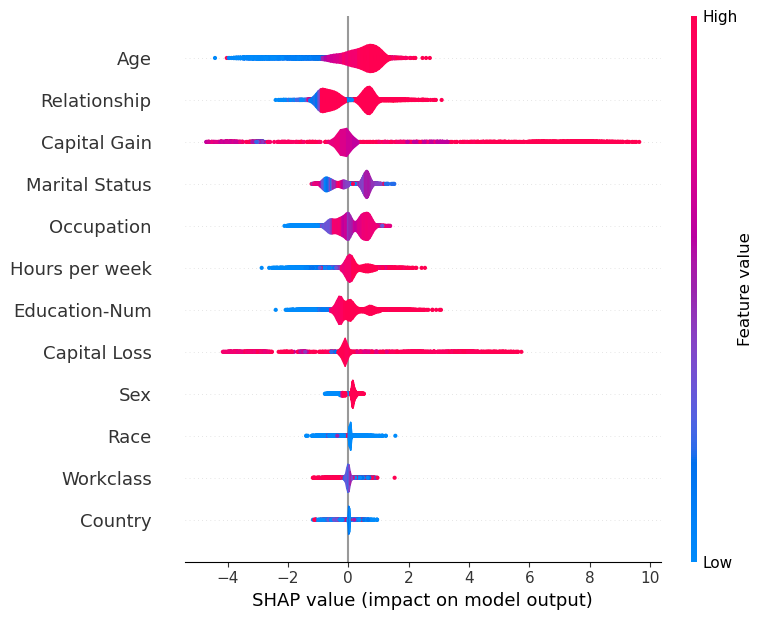

In [100]:
shap.summary_plot(shap_values, plot_type='violin')

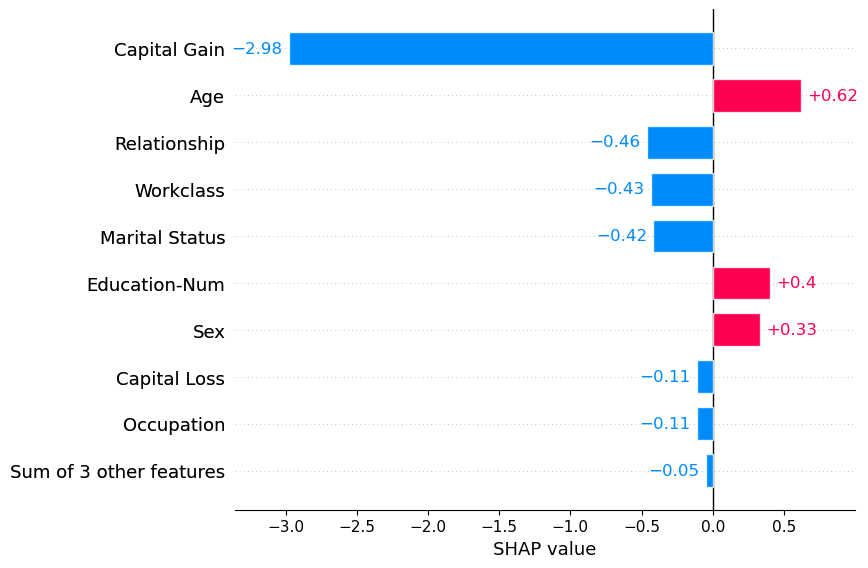

In [101]:
shap.plots.bar(shap_values[0])